## Running msprime simulations for a RoLE model

This notebook assumes you have msprime installed. If you want to run the notebook example you need
to also install several other packages to make the notebook work (see below).

Install msprime:

    conda install -c conda-forge msprime pandas
    conda install -c bioconda python-newick

Install for testing and dev inside jupyter notebooks:

    conda install -c conda-forge rpy2 r-irkernel

In [24]:
library(roleR)
library(ape)
library(reticulate)
## Assuming this function is available to me
newick <- function(phylo){
     ape_tree <- as(phylo, "phylo")
     write.tree(ape_tree, file = 'temp.nwk', append = FALSE, digits = 30, tree.names = FALSE)
     nwk <- readChar('temp.nwk', file.info('temp.nwk')$size)
     unlink('temp.nwk')
     return(nwk)
}
## init_type may be bridge_island or oceanic_island
p <- roleParams(individuals_local = 100, individuals_meta = 10000,
                         species_meta = 10, speciation_local = 0, 
                         speciation_meta = 0.05, extinction_meta = 0.05, env_sigma = 0.5,
                         trait_sigma=1, comp_sigma = 0.5, dispersal_prob = 0.01, mutation_rate = 1e-6,
                         equilib_escape = 1, num_basepairs = 500, alpha = 10000,
                         init_type = 'bridge_island', niter = 100000, niterTimestep = 10000)
model <- runRole(roleModel(p))
#localComm <- model@modelSteps[[targetStep]]@localComm
#print(slotNames(localComm))
#localComm@indSpecies
model@params@mutation_rate

[1] 1e-06

In [42]:
## Assumes you are passing in roleModel which has been run
sim_seqs <- function(model){
    source_python('role_msprime.py')
    #exp = as(model, "roleExperiment")

    ## the timesteps at which data were recorded
    ## TODO: Doing it this way because the as() above is broken atm
    iterations <- c(0, which(1:model@params@niter %% model@params@niterTimestep == 0))

    ## Global parameters
    J_m <- model@params@individuals_meta
    mu <- model@params@mutation_rate
    sequence_length <- model@params@num_basepairs
    
    ## For each snapshot
    for (idx in 1:length(model@modelSteps)){
        ## Fetch the data that we need to run the msprime simulation
        ## Current time in timesteps (necessary to get divergence counting from t_0)
        ## TODO: If as(model, "roleExperiment") works then you can do this instead.
        #curtime = exp@experimentMeta$iterations[[idx]]
        curtime = iterations[[idx]]

        ## Prior to iterFun it was done this way:
        ##J <- model@params@individuals_local[[idx]]
        J <- model@params@individuals_local(idx)
        alpha <- model@params@alpha(idx)
        
        metaTree <- newick(model@modelSteps[[idx]]@phylo)
        metaAbund <- model@modelSteps[[idx]]@metaComm@spAbund
        
        localAbund <- model@modelSteps[[idx]]@localComm@indSpecies
        spAbundHarmMean <- model@modelSteps[[idx]]@localComm@spAbundHarmMean
        localTDiv <- model@modelSteps[[idx]]@localComm@spLastOriginStep

        ## Returns a dataframe with rows for pi, TajD and genotypes
        res <- py_msprime_simulate(J_m, J, curtime, metaTree, metaAbund, localAbund,
                                   spAbundHarmMean, localTDiv, alpha, sequence_length, mu,
                                  verbose=TRUE)
        
        ## Update the model with the results
        model@modelSteps[[idx]]@localComm@spGenDiv = unlist(res["pi",])
        model@modelSteps[[idx]]@localComm@indSeqs = unlist(res["gtypes",])

    }
    return(model)
}
res <- sim_seqs(model)
res
#model@modelSteps[[10]]@localComm@spGenDiv

completed (run) RoLE model with 100000 iterations 

In [29]:
## Check the results
for (idx in 1:length(res@modelSteps)){
    print(res@modelSteps[[idx]]@localComm@spGenDiv)
    print(res@modelSteps[[idx]]@localComm@spAbund)
    print(res@modelSteps[[idx]]@localComm@spLastOriginStep)
}

    t1     t2     t3     t4     t5     t8 
0.7484 0.7250 0.6630 0.7102 0.6296 0.1228 
 [1] 65 19 10  4  1  0  0  1  0  0
 [1] 0 0 0 0 0 0 0 0 0 0
t1 t6 
 0  0 
 [1] 99  0  0  0  0  1  0  0  0  0
 [1]    0 9417 8211 5594 6646 9978    0    0    0    0
[1] 0.0024
 [1] 100   0   0   0   0   0   0   0   0   0
 [1]     0 18340 19000 12746  6646  9978     0     0     0     0
t1 t2 
 0  0 
 [1] 94  6  0  0  0  0  0  0  0  0
 [1]     0 29135 29442 26208 26634 23488     0     0     0     0
    t1     t5 
0.0016 0.0000 
 [1] 99  0  0  0  1  0  0  0  0  0
 [1]     0 39846 39338 39072 39964 39594     0     0     0     0
   t1    t6 
0e+00 8e-04 
 [1] 80  0  0  0  0 20  0  0  0  0
 [1]     0 49159 48675 48886 45776 40800     0     0     0     0
    t1     t2 
0.0024 0.0000 
 [1] 98  2  0  0  0  0  0  0  0  0
 [1]     0 59828 58084 48886 59042 58565     0     0     0 53476
    t1     t2 
0.0056 0.0000 
 [1] 71 29  0  0  0  0  0  0  0  0
 [1]     0 59828 68517 67786 69275 58565 65689     0     0 53476

In [23]:
res@modelSteps[[1]]

An object of class "roleData"
Slot "localComm":
An object of class "localComm"
Slot "indSpecies":
  [1] 1 2 1 4 1 1 5 2 1 2 1 1 5 2 1 7 3 2 1 2 3 4 8 1 1 1 2 1 1 1 1 4 1 1 1 1 4
 [38] 2 1 5 1 1 1 1 1 3 1 2 1 4 1 2 1 1 2 2 1 2 2 2 2 7 2 1 2 1 4 1 4 4 1 5 2 4
 [75] 1 7 5 2 1 1 4 1 3 1 2 6 4 1 1 3 5 1 1 2 1 4 1 1 1 1

Slot "indTrait":
        t1         t2         t1         t4         t1         t1         t5 
-18.550070 -16.498726 -18.550070 -51.161217 -18.550070 -18.550070  -7.093114 
        t2         t1         t2         t1         t1         t5         t2 
-16.498726 -18.550070 -16.498726 -18.550070 -18.550070  -7.093114 -16.498726 
        t1         t7         t3         t2         t1         t2         t3 
-18.550070 -19.915956   2.906249 -16.498726 -18.550070 -16.498726   2.906249 
        t4         t8         t1         t1         t1         t2         t1 
-51.161217   4.699591 -18.550070 -18.550070 -18.550070 -16.498726 -18.550070 
        t1         t1         t1         t

## Trash/experimentation below here

In [ ]:
print("  model slots")
print(slotNames(model))
print("  params slots")
print(slotNames(model@params))
print("  model step slots")
print(slotNames(model@modelSteps[[targetStep]]))
print("  metaComm slots")
print(slotNames(model@modelSteps[[targetStep]]@metaComm))
print("  localComm slots")
print(slotNames(model@modelSteps[[targetStep]]@localComm))

metaAbund <- model@modelSteps[[targetStep]]@metaComm@spAbund
localAbund <- model@modelSteps[[targetStep]]@localComm@spAbund
localTDiv <- model@modelSteps[[targetStep]]@localComm@spLastOriginStep

localComm <- model@modelSteps[[targetStep]]@localComm

[1] TRUE


[1] "((t5:49.22820084,t6:49.22820084):13.75104041,(((t1:0.2478452823,t10:0.2478452823):18.21871864,t7:18.46656392):11.6761168,(((t2:0.5968918004,t4:0.5968918004):9.243891552,t9:9.840783353):8.965020852,(t8:4.750494433,t3:4.750494433):14.05530977):11.33687651):32.83656054);\n"

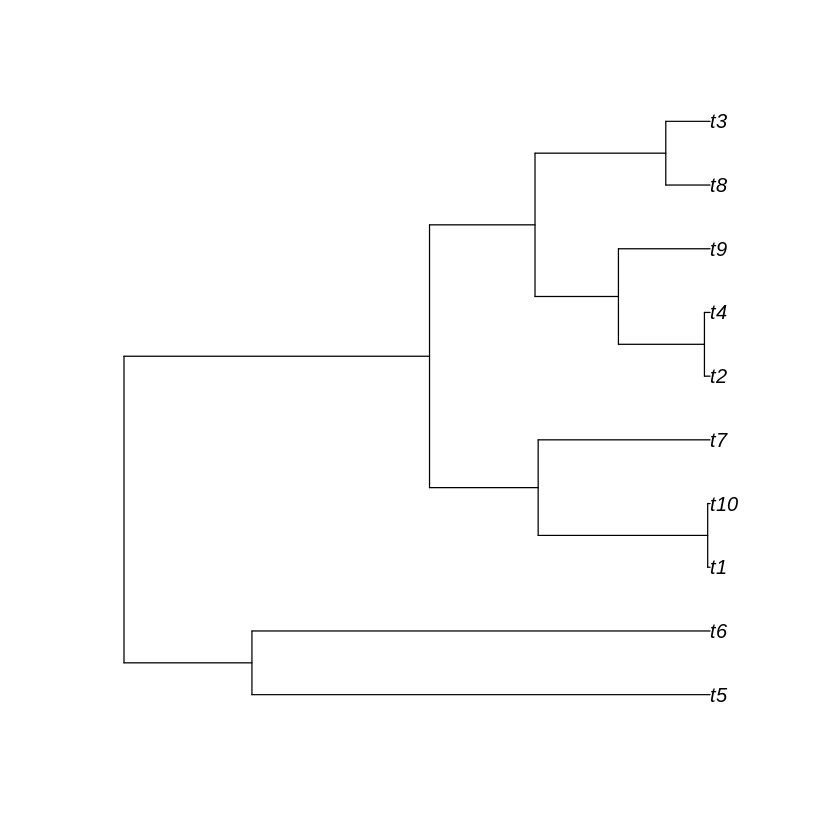

In [33]:
nwk <- newick(model@modelSteps[[1]]@phylo)
tre <- read.tree(text=nwk)
plot(tre)
print(is.ultrametric(tre))
nwk

In [29]:
exp = as(model, "roleExperiment")
exp@experimentMeta$iterations[[10]]

[1] 900

In [25]:
model@modelSteps[[targetStep]]@metaComm

An object of class "metaComm"
Slot "spAbund":
 [1] 0.597864769 0.211150652 0.096085409 0.047449585 0.023724792 0.011862396
 [7] 0.005931198 0.003558719 0.001186240 0.001186240

Slot "spTrait":
        t1         t2         t3         t4         t5         t6         t7 
 3.7429614 -3.6527011 -2.6361093  7.3320887  7.6553195  0.7792885  3.3310768 
        t8         t9        t10 
-3.1544467 -5.0519448  1.8750688 


In [128]:
model@modelSteps[[1]]@localComm

An object of class "localComm"
Slot "indSpecies":
  [1] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 [38] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 [75] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3

Slot "indTrait":
       t3        t3        t3        t3        t3        t3        t3        t3 
-1.761592 -1.761592 -1.761592 -1.761592 -1.761592 -1.761592 -1.761592 -1.761592 
       t3        t3        t3        t3        t3        t3        t3        t3 
-1.761592 -1.761592 -1.761592 -1.761592 -1.761592 -1.761592 -1.761592 -1.761592 
       t3        t3        t3        t3        t3        t3        t3        t3 
-1.761592 -1.761592 -1.761592 -1.761592 -1.761592 -1.761592 -1.761592 -1.761592 
       t3        t3        t3        t3        t3        t3        t3        t3 
-1.761592 -1.761592 -1.761592 -1.761592 -1.761592 -1.761592 -1.761592 -1.761592 
       t3        t3        t3        t3        t3        t3       

In [42]:
#length(model@modelSteps)
#as(model@params, "roleExperiment")
print(slotNames(model))
#roleExperiment(model)
#roleModel(model@params)
#exp = roleExperiment(c(model))
as(model, "roleExperiment")

[1] "params"     "modelSteps"


ERROR: Error in rep(p, length(j)): attempt to replicate an object of type 'closure'


In [134]:
msprime <- import("msprime")
#dbg = res$debug()
#ts = msprime$sim_ancestry(demography=res, samples=c(msprime$SampleSet(5, "t1_l")))
#ts = msprime$sim_mutations(ts, rate=0.001)
#ts$diversity()
res$events


[[1]]
InstantaneousBottleneck(time=-1.0, population='t2_l', strength=200000.0)

[[2]]
PopulationSplit(time=0.0, derived=['t2_m', 't2_l'], ancestral='t2')

[[3]]
PopulationSplit(time=1331907.0208397647, derived=['t2', 't6'], ancestral='pop_16')

[[4]]
PopulationSplit(time=4783267.451635439, derived=['t3', 't1'], ancestral='pop_11')

[[5]]
PopulationSplit(time=4791876.548620749, derived=['t10', 't5'], ancestral='pop_10')

[[6]]
PopulationSplit(time=6605008.217257258, derived=['t8', 't9'], ancestral='pop_12')

[[7]]
PopulationSplit(time=7520538.276588667, derived=['t7', 'pop_16'], ancestral='pop_17')

[[8]]
PopulationSplit(time=12879985.319674503, derived=['pop_12', 't4'], ancestral='pop_13')

[[9]]
PopulationSplit(time=13436309.741102647, derived=['pop_11', 'pop_13'], ancestral='pop_14')

[[10]]
PopulationSplit(time=15565051.333187427, derived=['pop_10', 'pop_14'], ancestral='pop_15')

[[11]]
PopulationSplit(time=53199837.632486254, derived=['pop_15', 'pop_17'], ancestral='pop_18')


In [171]:
print(model@modelSteps[[idx]]@phylo@l)
ph = model@modelSteps[[idx]]@phylo

wat = function(from) {
  i <- 2 * (from@n - 1)

  y <- list(edge = from@e[1:i, ], edge.length = from@l[1:i],
            tip.label = from@tipNames[1:from@n],
            Nnode = from@n - 1)

  # make any possible 0 or negative edge lengths equal to
  # very small number
  print(y$edge.length <= 0)
  y$edge.length[y$edge.length <= 0] <- .Machine$double.eps

  class(y) <- 'phylo'

  return(y)
}
ape_tr = wat(ph)
is.ultrametric(ape_tr)
ape_tr$edge.length
newick(ape_tr)

 [1] 121.5470484  18.9334488   0.2743390   9.7965882   2.4511238   2.4511238
 [7]  12.2477120  12.5220511  31.4554998 133.0790557  16.3437354   2.3976470
[13]   1.1821101   1.1821101   2.5928645   0.9868926   0.9868926  19.9234925
 [1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[13] FALSE FALSE FALSE FALSE FALSE FALSE


[1] TRUE

[1] 121.5470484  18.9334488   0.2743390   9.7965882   2.4511238   2.4511238
 [7]  12.2477120  12.5220511  31.4554998 133.0790557  16.3437354   2.3976470
[13]   1.1821101   1.1821101   2.5928645   0.9868926   0.9868926  19.9234925

[1] "(((((t6:2.45112382300675335500272922218,t8:2.45112382300675335500272922218):9.79658819007364911612967262045,t3:12.2477120130804024711324018426):0.274339041983090226040076231584,t4:12.5220510550634926971724780742):18.933448771541357302794494899,t10:31.4554998266048499999669729732):121.547048353778492923993326258,(((t5:1.18211007899886055838578613475,t1:1.18211007899886055838578613475):2.39764699703194139601691858843,(t7:0.98689255753362914447279763408,t2:0.98689255753362914447279763408):2.5928645184971728099299070891):16.3437354032475887777309253579,t9:19.9234924792783907321336300811):133.07905570110494863911299035);\n"